# Import packages

In [1]:
# %matplotlib notebook
from utils import *
from metrics import *
import time
import os

# algorithms
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

from pymoo.factory import get_termination
from pymoo.util.termination import collection

import plotly.express as px
from ipywidgets import *
from skimage.util import compare_images

import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as mape

# Reference image

In [2]:
# Image 5
ground_truth_name = '01019-s1-1'
save_results_path = 'image5/nsga3/image5-'

In [3]:
image_path = 'input_data/' + ground_truth_name + '.png'
ground_truth_raw, ground_truth = getTargetImage(image_path,0,log=False)

ground_truth_min, ground_truth_max = ground_truth.min(), ground_truth.max()
print(ground_truth_raw.min(), ground_truth_raw.max())
print(ground_truth_min, ground_truth_max)

128.0 255.0
-3.7655115 0.59044015


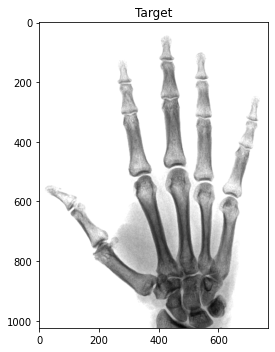

In [4]:
plt.figure(figsize= (5,5))
plt.title("Target")
plt.imshow(ground_truth, cmap='gray')
# plt.axis('off')

plt.tight_layout()


### Pad ground truth, make sure wrist is centred

-3.7655115 0.59044015


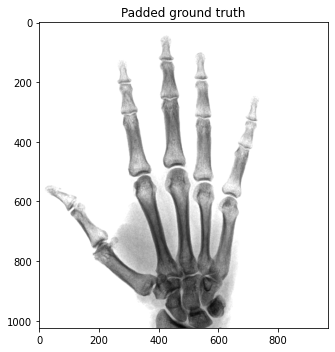

In [5]:
# pad 200 pixels for Image 5, and 100 for Image 8 and 9
pad_width = 200
ground_truth_pad = np.pad(ground_truth, ((0,0),(0,pad_width)), 'constant', constant_values=ground_truth_max)

print(ground_truth_pad.min(), ground_truth_pad.max())

plt.figure(figsize= (5,5))
plt.title("Padded ground truth")
plt.imshow(ground_truth_pad, cmap='gray')
# plt.axis('off')

plt.tight_layout()

In [6]:
log_ground_truth_raw, log_ground_truth = getTargetImage(image_path,0,log=True)

# use log image
# ground_truth = log_ground_truth

### Image sharpening 

In [7]:
kernel_size = 2
scaling = 5

### Use padded image

In [8]:

ground_truth_sharpen = addSharpenFilterNormalise(ground_truth_pad, kernel_size, scaling, ground_truth_pad.min(), ground_truth_pad.max())


### Use original normalised image

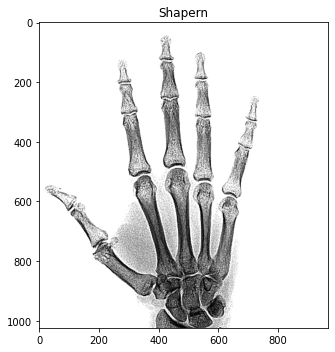

In [9]:

plt.figure(figsize= (5,5))
plt.title("Shapern")
plt.imshow(ground_truth_sharpen, cmap='gray')
# plt.axis('off')

plt.tight_layout()

# 3D hand model

In [10]:
hand_model = plt.imread('input_data/hand_model.png')

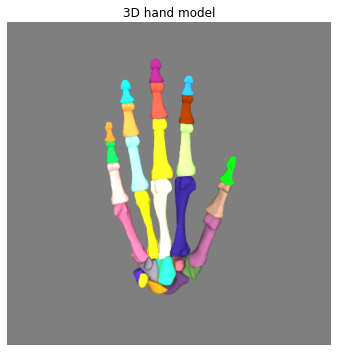

In [11]:
plt.figure(figsize= (10,5))
plt.title("3D hand model")
plt.imshow(hand_model)
plt.axis('off')

plt.tight_layout()

# Set X-ray simulation parameters

In [12]:
model_path = 'input_data/hand.dae'

# add pixels on detector
setXRayEnvironment(model_path, 0, addWidth=pad_width, addHeight=0) 

In [13]:
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = (x_ray_image-x_ray_image.mean())/x_ray_image.std()

x_ray_image_min, x_ray_image_max = x_ray_image.min(), x_ray_image.max()
print(x_ray_image_min, x_ray_image_max)

-7.273804823493235 0.4303915343399307


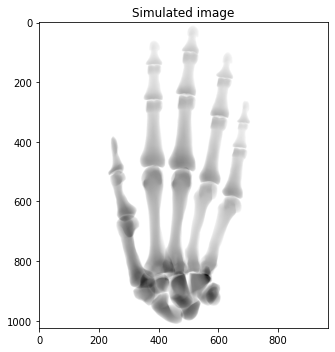

In [14]:
plt.figure(figsize= (10,5))
plt.title("Simulated image")
plt.imshow(x_ray_image, cmap='gray')
# plt.axis('off')

plt.tight_layout()

In [15]:
x_ray_image_sharpen = addSharpenFilterNormalise(x_ray_image, kernel_size, scaling, x_ray_image_min, x_ray_image_max)

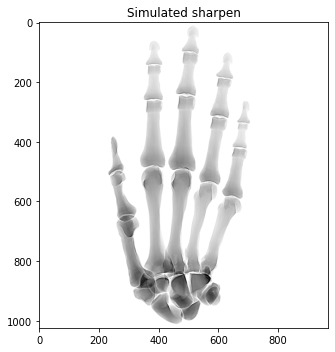

In [16]:
plt.figure(figsize= (10,5))
plt.title("Simulated sharpen")
plt.imshow(x_ray_image_sharpen, cmap='gray')
# plt.axis('off')

plt.tight_layout()

# Matching fingers by hand

# CMA-ES

# NSGA-II

In [17]:
# define boundaries
xl = np.array([0.7, 10., -2., -2., -2.,
            -40., -20., -10.,
            -30., -20., -20., -20.,
            -10., -20., -20., -20.,
            -10., -20., -20. ,-20.,
            0., -20., -20., -20.,
            0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

xu = np.array([0.95, 1000., 2., 2., 2.,
            10., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            30., 0., 0., 0.,
            1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

# ground truth to be used
ground_truth_to_optimise = ground_truth_sharpen

In [18]:
def objectiveFunction(aPrediction):

    obj_list = []

    for i in aPrediction:

        pred_image = computePredictedImage(i)
        pred_image = addSharpenFilterNormalise(pred_image, kernel_size, scaling, pred_image.min(), pred_image.max())

        row = []

        dzncc = (1.0 - ZNCC(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dzncc)
        
        dssim = (1.0 - SSIM(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dssim)

        mae = MAE(ground_truth_to_optimise, pred_image)
        row.append(mae)

        rmse = RMSE(ground_truth_to_optimise, pred_image)
        row.append(rmse)

        dmi = (2.0 - MI(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dmi)
        
        # Avoid div by 0
        offset1 = min(standardised_roi_ground_truth.min(), standardised_corrected_xray_image.min())
        offset2 = 0.01 * (standardised_roi_ground_truth.max() - standardised_roi_ground_truth.min())
        offset = offset2 - offset1
        mape_value = mape(standardised_roi_ground_truth + offset, standardised_corrected_xray_image + offset)
        row.append(mape_value)
        
        obj_list.append(row)


    return obj_list

In [19]:
class multiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=38, 
                         n_obj=6, 
                         n_constr=0, 
                         xl=xl,
                         xu=xu)


    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunction(x))
        

In [20]:


problem = multiObjectiveProblem()

pop_size = 100

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)
# False: #
if False: #os.path.exists(save_results_path+"nsga2-X.dat") and os.path.exists(save_results_path+"nsga2-F.dat"):

    res_nsga2_X = np.loadtxt(save_results_path+"nsga2-X.dat")
    res_nsga2_F = np.loadtxt(save_results_path+"nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True)

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt(save_results_path+"nsga2-X.dat", res_nsga2_X)
    np.savetxt(save_results_path+"nsga2-F.dat", res_nsga2_F)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       1 |            - |            -


/home/ti/.local/lib/python3.8/site-packages/pymoo/util/normalization.py:73: RuntimeWarning: invalid value encountered in greater_equal
  assert np.all(np.logical_or(xu >= xl, any_nan)), "xl must be less or equal than xu."


    2 |     200 |       1 |  0.00000E+00 |            f
    3 |     300 |       1 |  0.000978449 |            f
    4 |     400 |       2 |  2.267868102 |        ideal
    5 |     500 |       3 |  0.560312118 |        ideal
    6 |     600 |       4 |  0.433878203 |        ideal
    7 |     700 |       2 |  3.643884654 |        ideal
    8 |     800 |       3 |  0.561640647 |        ideal
    9 |     900 |       5 |  0.145973668 |        ideal
   10 |    1000 |       4 |  0.269285558 |        ideal
   11 |    1100 |       8 |  0.223467504 |        ideal
   12 |    1200 |       5 |  0.225564953 |        ideal
   13 |    1300 |       7 |  0.091992596 |            f
   14 |    1400 |       5 |  0.161914110 |        ideal
   15 |    1500 |       6 |  0.264823844 |        ideal
   16 |    1600 |       7 |  0.147008010 |        ideal
   17 |    1700 |       8 |  0.040512282 |        ideal
   18 |    1800 |      10 |  0.128800416 |        ideal
   19 |    1900 |       8 |  0.116630805 |      

In [22]:
best_dzncc_id = np.argmin(res_nsga2_F[:,0])
best_mae_id = np.argmin(res_nsga2_F[:,1])

# best_dssim_id = np.argmin(res_nsga2_F[:,1])
# best_mae_id = np.argmin(res_nsga2_F[:,2])
# best_rmse_id = np.argmin(res_nsga2_F[:,3])
# best_dmi_id = np.argmin(res_nsga2_F[:,4])

print("Lowest DZNCC:", res_nsga2_F[:,0].min(), best_dzncc_id, res_nsga2_X[best_dzncc_id])
print("Lowest MAE:",   res_nsga2_F[:,1].min(), best_mae_id,   res_nsga2_X[best_mae_id])

# print("Lowest DSSIM:", res_nsga2_F[:,1].min(), best_dssim_id, res_nsga2_X[best_dssim_id])
# print("Lowest MAE:",   res_nsga2_F[:,2].min(), best_mae_id,   res_nsga2_X[best_mae_id])
# print("Lowest RMSE:",  res_nsga2_F[:,3].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
# print("Lowest DMI:",  res_nsga2_F[:,4].min(), best_dmi_id,  res_nsga2_X[best_dmi_id])

Lowest DZNCC: 0.2981116837039418 45 [ 9.49695020e-01  9.58280947e+02 -1.99777535e+00  1.73922645e+00
  1.99838185e+00 -6.82602141e+00 -1.47652164e+01 -9.99179526e+00
 -7.37242473e+00 -1.54364035e+01 -1.74924398e+01 -1.39789068e+01
  2.30161622e+00 -1.93812019e+01 -6.79252665e+00 -1.20302377e+01
  7.81153161e+00 -1.75406927e+01 -1.88482005e+01 -5.51097021e+00
  2.99858266e+01 -8.03133776e+00 -1.74944574e+01 -4.48744530e+00
  9.03860028e-01  1.03357038e+00  1.01344431e+00  9.30634313e-01
  1.00531815e+00  1.09841430e+00  9.29012277e-01  1.01503051e+00
  9.33880491e-01  1.09879653e+00  1.06327266e+00  9.23199360e-01
  1.06248373e+00  1.03737589e+00]
Lowest MAE: 0.5680617133805624 53 [ 8.93033819e-01  9.65011994e+02 -1.99753168e+00 -1.98292011e+00
  1.99646128e+00 -4.91416197e+00 -1.48256463e+01 -9.99556648e+00
 -8.03878801e+00 -1.92586268e+01 -1.68116146e+01 -1.36867629e+01
  2.30015552e+00 -1.99270993e+01 -7.71758378e+00 -1.15612269e+01
  6.04652827e+00 -1.94312501e+01 -1.63533939e+01 -8

In [23]:
xray_image_dzncc_nsga2 = computePredictedImage(res_nsga2_X[best_dzncc_id])
# xray_image_dssim_nsga2   = computePredictedImage(res_nsga2_X[best_dssim_id])
xray_image_mae_nsga2  = computePredictedImage(res_nsga2_X[best_mae_id])
# xray_image_rmse_nsga2 = computePredictedImage(res_nsga2_X[best_rmse_id])
# xray_image_dmi_nsga2  = computePredictedImage(res_nsga2_X[best_dmi_id])

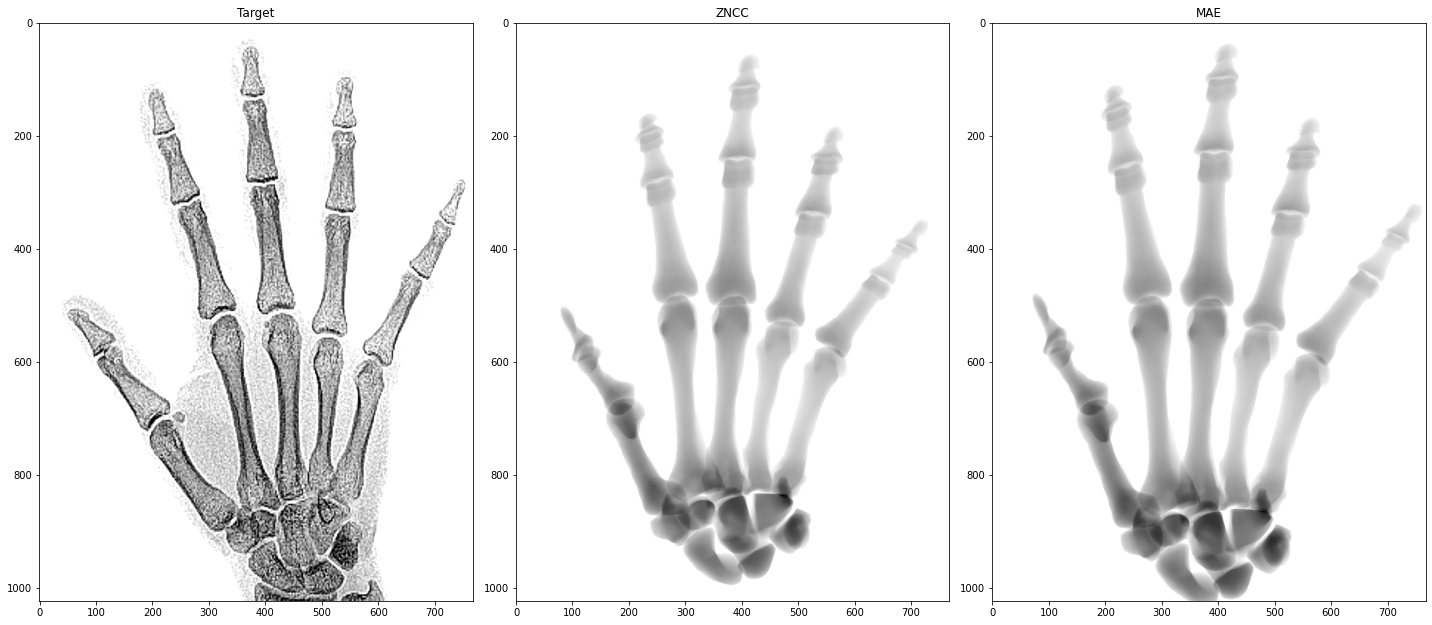

In [24]:
plt.figure(figsize= (20,10))

# plt.suptitle("Results")

plt.subplot(131)
plt.imshow(ground_truth_sharpen, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(132)
plt.imshow(xray_image_dzncc_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("ZNCC")

# plt.subplot(163)
# plt.imshow(xray_image_dssim_nsga2, cmap="gray")
# # plt.colorbar(orientation='horizontal')
# plt.title("SSIM")

plt.subplot(133)
plt.imshow(xray_image_mae_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAE")

# plt.subplot(165)
# plt.imshow(xray_image_rmse_nsga2, cmap="gray")
# # plt.colorbar(orientation='horizontal')
# plt.title("RMSE")

# plt.subplot(166)
# plt.imshow(xray_image_dmi_nsga2, cmap="gray")
# # plt.colorbar(orientation='horizontal')
# plt.title("MI")

plt.tight_layout()

plt.savefig(save_results_path+'nsga2.pdf')
plt.savefig(save_results_path+'nsga2.png')

In [25]:
df_nsga2 = pd.DataFrame(data=np.append(res_nsga2_X, res_nsga2_F, axis=1),
                  columns=["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9",
                           "x10", "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19",
                           "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29",
                           "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37",
                           "DZNCC", "MAE"])

df_nsga2.to_csv(save_results_path+"-nsga2.csv")
print(df_nsga2)

          x0          x1        x2        x3        x4        x5         x6  \
0   0.948662  948.383109 -1.997775  1.739226  1.998454 -6.826021 -14.765216   
1   0.916730  950.790890 -1.994777 -1.716706  1.999632 -6.543925 -14.516609   
2   0.899657  973.735582 -1.998548 -1.999187  1.999345 -4.955127 -14.847635   
3   0.895774  964.989712 -1.998619 -1.839740  1.996287 -4.734905 -14.454371   
4   0.945041  957.414325 -1.999310  1.739492  1.998367 -6.826416 -14.766134   
5   0.916730  950.093829 -1.995210 -1.706023  1.999628 -6.543925 -14.516609   
6   0.916638  971.457824 -1.995093 -1.846801  1.998842 -6.054480 -14.516609   
7   0.948662  958.280947 -1.997775  1.739226  1.998382 -6.826021 -14.765216   
8   0.899657  973.735582 -1.998548 -1.999187  1.999345 -4.955127 -14.847635   
9   0.941719  975.967227 -1.995359 -1.969351  1.998825 -8.276745 -14.349578   
10  0.899947  973.738887 -1.997955 -1.999187  1.999345 -4.919464 -14.847662   
11  0.919996  964.567296 -1.995188 -1.962944  1.9979

In [26]:
fig = px.parallel_coordinates(df_nsga2[["DZNCC", "MAE"]], color="DZNCC")
fig.show()

fig.write_image(save_results_path+"NSGA2-parcoords.pdf", engine="kaleido")
fig.write_image(save_results_path+"NSGA2-parcoords.png", engine="kaleido")

In [31]:
fig = px.scatter(x=res_nsga2_F[:,1],y=res_nsga2_F[:,0])

fig.update_layout(
    height=800,
    width=800
)

fig.show()

fig.write_image(save_results_path+"NSGA2-scatter_matrix.pdf", engine="kaleido")
fig.write_image(save_results_path+"NSGA2-scatter_matrix.png", engine="kaleido")

# Compute orignal images, metrics

In [ ]:
# select best individual
total_number_of_params = 38
ind = np.argmin(np.array(df_nsga2.loc[:,'DZNCC']))
print(ind)

In [ ]:
# Compute x-ray images
x_list = []
for p in range(total_number_of_params):
    x = "x" + str(p)
    x_list.append(df_nsga2.loc[ind,x])
x_list=np.array(x_list)

x_ray_image = computePredictedImage(x_list)
x_ray_image = x_ray_image[:,:768]

In [ ]:
# remove padding, compute metrics 
zncc = ZNCC(ground_truth, x_ray_image)
ssim = SSIM(ground_truth, x_ray_image)
mae = MAE(ground_truth, x_ray_image)
rmse = RMSE(ground_truth, x_ray_image)
mi = MI(ground_truth, x_ray_image)

np.savetxt(save_results_path+"nsga2-final-F.dat", [zncc,ssim,mae,rmse,mi])

print('ZNCC:', zncc, 'SSIM:', ssim, 'MAE:', mae, 'RMSE:', rmse, 'MI:', mi)

In [ ]:


comp_checkerboard = compare_images(ground_truth, x_ray_image, method='checkerboard')
comp_diff = abs(ground_truth-x_ray_image)

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(ground_truth, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(142)
plt.imshow(x_ray_image, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Simulated")

plt.subplot(143)
plt.imshow(comp_checkerboard, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Checkerboard")

plt.subplot(144)
plt.imshow(comp_diff, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Diff")

plt.tight_layout()

plt.savefig(save_results_path+'optimised-nsga2.pdf')
plt.savefig(save_results_path+'optimised-nsga2.png')

# NSGA-III

In [17]:
# define boundaries
xl = np.array([0.7, 10., -2., -2., -2.,
            -40., -20., -10.,
            -30., -20., -20., -20.,
            -10., -20., -20., -20.,
            -10., -20., -20. ,-20.,
            0., -20., -20., -20.,
            0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
            -2.,-2.,-2.,-2.,-2.,-2.,-2.,-2.])

xu = np.array([0.95, 1000., 2., 2., 2.,
            10., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            30., 0., 0., 0.,
            1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1,
            2.,2.,2.,2.,2.,2.,2.,2.])

# ground truth to be used
ground_truth_to_optimise = ground_truth_sharpen

In [18]:
def objectiveFunction(aPrediction):

    obj_list = []

    for i in aPrediction:

        pred_image = computePredictedImage(i)
        pred_image = addSharpenFilterNormalise(pred_image, kernel_size, scaling, pred_image.min(), pred_image.max())

        row = []

        dzncc = (1.0 - ZNCC(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dzncc)
        
        dssim = (1.0 - SSIM(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dssim)

        mae = MAE(ground_truth_to_optimise, pred_image)
        row.append(mae)

        rmse = RMSE(ground_truth_to_optimise, pred_image)
        row.append(rmse)

        dmi = (2.0 - MI(ground_truth_to_optimise, pred_image)) / 2.0
        row.append(dmi)
        
        # Avoid div by 0
        offset1 = min(ground_truth_to_optimise.min(), pred_image.min())
        offset2 = 0.01 * (ground_truth_to_optimise.max() - ground_truth_to_optimise.min())
        offset = offset2 - offset1
        mape_value = mape(ground_truth_to_optimise + offset, pred_image + offset)
        row.append(mape_value)
        
        obj_list.append(row)


    return obj_list

In [19]:
class multiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=46, 
                         n_obj=6, 
                         n_constr=0, 
                         xl=xl,
                         xu=xu)


    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunction(x))
        

In [20]:
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.factory import get_reference_directions

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if False: #os.path.exists(save_results_path+"nsga2-X.dat") and os.path.exists(save_results_path+"nsga2-F.dat"):

    res_nsga2_X = np.loadtxt(save_results_path+"nsga2-X.dat")
    res_nsga2_F = np.loadtxt(save_results_path+"nsga2-F.dat")

else:
    
    n_objs = 6
    n_partitions = 6

    ref_dirs = get_reference_directions("das-dennis", n_objs, n_partitions=n_partitions)

    problem = multiObjectiveProblem()

    pop_size = 462 #2 * ref_dirs.shape[0]

    algorithm = NSGA3(
        pop_size=pop_size,
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )


    res_nsga3 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga3_X = res_nsga3.X
    res_nsga3_F = res_nsga3.F

    np.savetxt(save_results_path+"nsga3-X.dat", res_nsga3_X)
    np.savetxt(save_results_path+"nsga3-F.dat", res_nsga3_F)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     462 |       4 |            - |            -


/home/ti/.local/lib/python3.8/site-packages/pymoo/util/normalization.py:73: RuntimeWarning: invalid value encountered in greater_equal
  assert np.all(np.logical_or(xu >= xl, any_nan)), "xl must be less or equal than xu."


    2 |     924 |       1 |  0.017803291 |        ideal
    3 |    1386 |       3 |  1.000000000 |        ideal
    4 |    1848 |       5 |  0.441678763 |        nadir
    5 |    2310 |       2 |  1.078742738 |        ideal
    6 |    2772 |       5 |  0.570450135 |        ideal
    7 |    3234 |       6 |  0.627142655 |        ideal
    8 |    3696 |       6 |  0.060606029 |        ideal
    9 |    4158 |      10 |  0.097424490 |        ideal
   10 |    4620 |       8 |  0.013739618 |        ideal
   11 |    5082 |      10 |  0.271822436 |        ideal
   12 |    5544 |       9 |  0.067220698 |        ideal
   13 |    6006 |       5 |  0.291181280 |        ideal


In [21]:
best_dzncc_id = np.argmin(res_nsga3_F[:,0])
best_dssim_id = np.argmin(res_nsga3_F[:,1])
best_mae_id = np.argmin(res_nsga3_F[:,2])
best_rmse_id = np.argmin(res_nsga3_F[:,3])
best_dmi_id = np.argmin(res_nsga3_F[:,4])
best_mape_id = np.argmin(res_nsga3_F[:,5])

print("Lowest DZNCC:", res_nsga3_F[:,0].min(), best_dzncc_id, res_nsga3_X[best_dzncc_id])
print("Lowest DSSIM:", res_nsga3_F[:,1].min(), best_dssim_id, res_nsga3_X[best_dssim_id])
print("Lowest MAE:",   res_nsga3_F[:,2].min(), best_mae_id,   res_nsga3_X[best_mae_id])
print("Lowest RMSE:",  res_nsga3_F[:,3].min(), best_rmse_id,  res_nsga3_X[best_rmse_id])
print("Lowest DMI:",  res_nsga3_F[:,4].min(), best_dmi_id,  res_nsga3_X[best_dmi_id])
print("Lowest MAPE:",   res_nsga3_F[:,5].min(), best_mape_id,   res_nsga3_X[best_mape_id])


Lowest DZNCC: 0.18229560567673814 3 [ 8.75174550e-01  9.74676315e+02 -1.56460802e+00  1.05505364e+00
  1.35304685e+00 -2.86062376e+01 -1.72074826e+01 -4.68438269e+00
 -1.66083950e+01 -1.18778552e+01 -1.57829591e+01 -1.00930745e+01
 -8.34603179e+00 -4.17721257e+00 -7.66997587e-02 -5.46249450e+00
 -8.28994524e+00 -9.78209769e+00 -1.33322497e+01 -1.84574334e+01
  8.49486068e+00 -1.50394424e+01 -1.80724268e+01 -5.66668311e+00
  9.53306469e-01  1.05591428e+00  9.83196798e-01  9.71552943e-01
  9.03484198e-01  9.03555680e-01  9.25384726e-01  9.20602607e-01
  1.02430460e+00  9.65880620e-01  1.04681084e+00  1.07970618e+00
  1.09672147e+00  9.14605071e-01 -1.71026568e+00  1.75998268e+00
 -1.96316016e+00 -4.41581659e-02 -1.96039411e+00 -1.33002854e+00
 -1.36526044e+00 -1.15134027e+00]
Lowest DSSIM: 0.15480894860857464 2 [  0.89418947 737.58601688  -0.86109444   1.36737635   1.09646593
   9.30534588  -5.43601324  -7.77368334 -20.14713    -13.86674352
 -19.04867172 -17.68519022  -8.0417696   -7.184

In [22]:
xray_image_dzncc_nsga3 = computePredictedImage(res_nsga3_X[best_dzncc_id])
xray_image_dssim_nsga3   = computePredictedImage(res_nsga3_X[best_dssim_id])
xray_image_mae_nsga3  = computePredictedImage(res_nsga3_X[best_mae_id])
xray_image_rmse_nsga3 = computePredictedImage(res_nsga3_X[best_rmse_id])
xray_image_dmi_nsga3  = computePredictedImage(res_nsga3_X[best_dmi_id])
xray_image_mape_nsga3  = computePredictedImage(res_nsga3_X[best_mape_id])

xray_image_dzncc_nsga3 = xray_image_dzncc_nsga3[:,:768]
xray_image_dssim_nsga3 = xray_image_dssim_nsga3[:,:768]
xray_image_mae_nsga3 = xray_image_mae_nsga3[:,:768]
xray_image_rmse_nsga3 = xray_image_rmse_nsga3[:,:768]
xray_image_dmi_nsga3 = xray_image_dmi_nsga3[:,:768]
xray_image_mape_nsga3 = xray_image_mape_nsga3[:,:768]



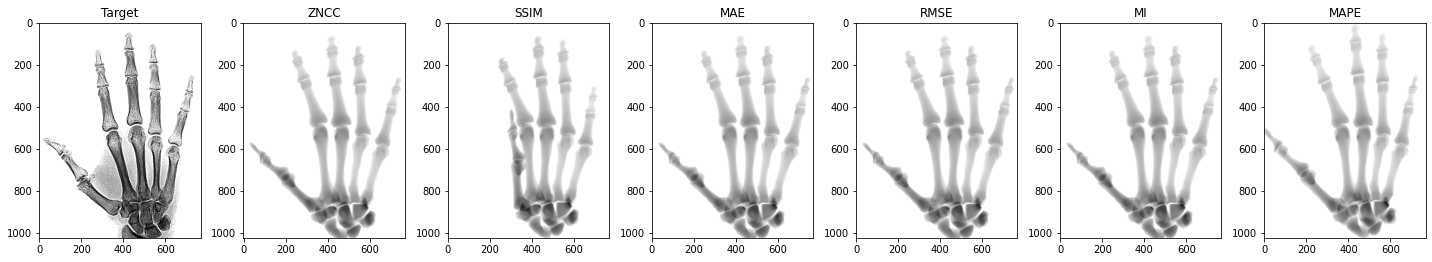

In [23]:
ground_truth_to_optimise = ground_truth_to_optimise[:,:768]

plt.figure(figsize= (20,10))

# plt.suptitle("Results")

plt.subplot(171)
plt.imshow(ground_truth_to_optimise, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(172)
plt.imshow(xray_image_dzncc_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("ZNCC")

plt.subplot(173)
plt.imshow(xray_image_dssim_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("SSIM")

plt.subplot(174)
plt.imshow(xray_image_mae_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAE")

plt.subplot(175)
plt.imshow(xray_image_rmse_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("RMSE")

plt.subplot(176)
plt.imshow(xray_image_dmi_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MI")

plt.subplot(177)
plt.imshow(xray_image_mape_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAPE")


plt.tight_layout()

plt.savefig(save_results_path+'nsga3.pdf')
plt.savefig(save_results_path+'nsga3.png')

In [24]:
plt.imsave(save_results_path+"nsga3-zncc.png", xray_image_dzncc_nsga3, cmap='gray')
plt.imsave(save_results_path+"nsga3-ssim.png", xray_image_dssim_nsga3, cmap='gray')
plt.imsave(save_results_path+"nsga3-mae.png", xray_image_mae_nsga3, cmap='gray')
plt.imsave(save_results_path+"nsga3-rmse.png", xray_image_rmse_nsga3, cmap='gray')
plt.imsave(save_results_path+"nsga3-mi.png", xray_image_dmi_nsga3, cmap='gray')
plt.imsave(save_results_path+"nsga3-mape.png", xray_image_mape_nsga3, cmap='gray')

In [25]:
# remove padding, compute metrics 


best_value_zncc = ZNCC(ground_truth_to_optimise, xray_image_dzncc_nsga3)
best_value_ssim = SSIM(ground_truth_to_optimise, xray_image_dssim_nsga3)
best_value_mae = MAE(ground_truth_to_optimise, xray_image_mae_nsga3)
best_value_rmse = RMSE(ground_truth_to_optimise, xray_image_rmse_nsga3)
best_value_mi = MI(ground_truth_to_optimise, xray_image_dmi_nsga3)

offset1 = min(ground_truth_to_optimise.min(), xray_image_mape_nsga3.min())
offset2 = 0.01 * (ground_truth_to_optimise.max() - ground_truth_to_optimise.min())
offset = offset2 - offset1
best_value_mape = mape(ground_truth_to_optimise + offset, xray_image_mape_nsga3 + offset)

np.savetxt(save_results_path+"nsga3-final-F.dat", [best_value_zncc,best_value_ssim,best_value_mae,best_value_rmse,best_value_mi,best_value_mape])

print("ZNCC:", best_value_zncc)
print("SSIM:", best_value_ssim)
print("MAE:",  best_value_mae)
print("RMSE:", best_value_rmse)
print("MI:",  best_value_mi)
print("MAPE:",  best_value_mape)

ZNCC: 0.6288699812225261
SSIM: 0.6133122044219701
MAE: 0.4777465951732014
RMSE: 0.9398434957756381
MI: 1.0697779191895496
MAPE: 0.0873303210326537


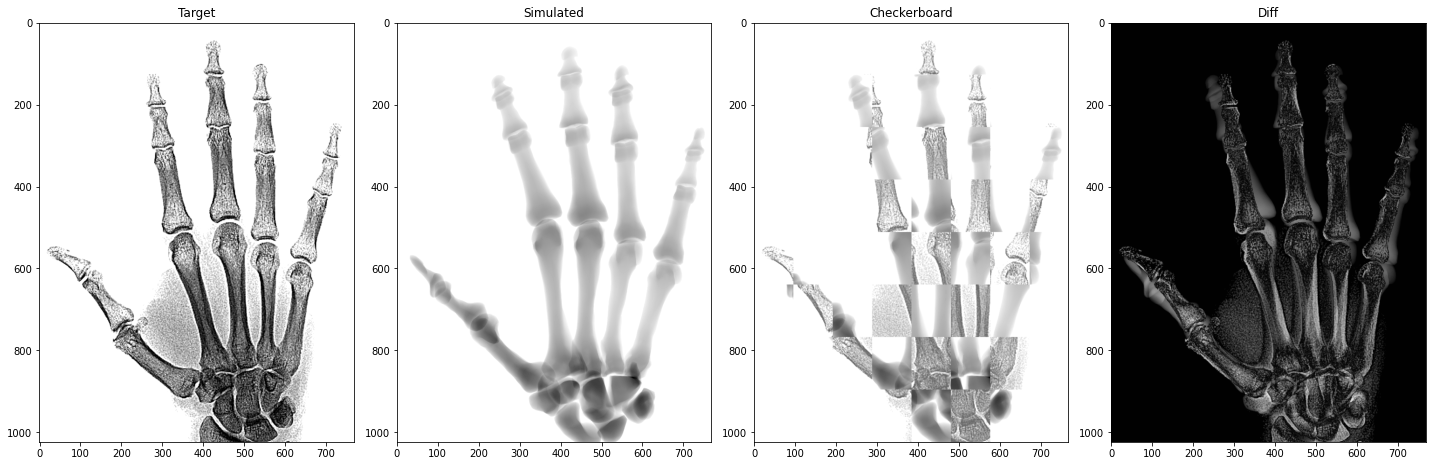

In [26]:

comp_checkerboard = compare_images(ground_truth_to_optimise, xray_image_dzncc_nsga3, method='checkerboard')
comp_diff = abs(ground_truth_to_optimise-xray_image_dzncc_nsga3)

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(ground_truth_to_optimise, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(142)
plt.imshow(xray_image_dzncc_nsga3, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Simulated")

plt.subplot(143)
plt.imshow(comp_checkerboard, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Checkerboard")

plt.subplot(144)
plt.imshow(comp_diff, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Diff")

plt.tight_layout()

plt.savefig(save_results_path+'optimised-nsga3.pdf')
plt.savefig(save_results_path+'optimised-nsga3.png')
